# TP 1 - Tópicos de Minería de Datos
### Juan Ignacio Farizano

--------------------------------------------------------------------------------

In [48]:
# Imports iniciales
library(data.table)
library(ggplot2)
library(caret)
library(party)
library(class)

--------------------------------------------------------------------------------
## Ejercicio 1

In [41]:
# Punto a
generatePoints <- function(d, n, std, center0, center1) {
  lenClass1 <- floor(n / 2)
  lenClass0 <- n - lenClass1

  class0 <- replicate(n = lenClass0, as.list(c(rnorm(d, mean = center0, sd = std), 0)), simplify = FALSE)
  class1 <- replicate(n = lenClass1, as.list(c(rnorm(d, mean = center1, sd = std), 1)), simplify = FALSE)
  data <- c(class0, class1)

  df <- rbindlist(data)
  colnames(df) <- c(seq(1, d), "Class")
  df <- as.data.frame(df)
  df$Class <- as.factor(df$Class)
  df
}

generateDiagonal <- function(d, n, C) {
  generatePoints(d, n, C * sqrt(d), rep(-1, d), rep(1, d))
}

In [3]:
# Punto b
cartesianToPolar <- function(x, y){
  ro = sqrt(x ** 2 + y ** 2)

  if (x > 0 && y >= 0) {
    theta = atan(y / x)
  } else if (x == 0 && y > 0) {
    theta = pi / 2
  } else if (x < 0) {
    theta = atan(y / x) + pi
  } else if (x == 0 && y < 0) {
    theta = (3 * pi) / 2
  } else if (x > 0 && y < 0) {
    theta = atan(y / x) + 2 * pi
  }

  c(ro, theta)
}

# Básicamente robé mi código de IAA y lo adapté a R
generateSpirals <- function(n) {
  radius = 1
  centerX <- 0
  centerY <- 0

  # Si n es impar la clase 0 va a tener un elemento más que la clase 1
  lenClass1 <- floor(n / 2)
  lenClass0 <- n - lenClass1

  # Ints para iterar sobre la cantidad actual de puntos generados para cada clase
  cantClass0 = 0
  cantClass1 = 0

  data <- data.frame()

  # No sé si habrá una forma vectorial más fácil de hacer esto
  while (cantClass0 < lenClass0 || cantClass1 < lenClass1) {
    y <- runif(1, min = -1, max = 1)
    x <- runif(1, min = -1, max = 1)

    polarCoords <- cartesianToPolar(x, y)
    ro <- polarCoords[1]
    theta <- polarCoords[2]


    if (ro <= 1) {
      betweenCurves <- FALSE

      for (theta0 in (theta + (2 * pi * seq(-1, 6)))) {
        if ((theta0 / (4 * pi)) <= ro && ro <= ((theta0 + pi) / (4 * pi))) {
          if (cantClass0 < lenClass0) {
            data <- rbind(data, c(x, y, 0))
            cantClass0 <- cantClass0 + 1
          }
          betweenCurves <- TRUE
          next
        }
      }

      if (cantClass1 < lenClass1 && !betweenCurves) {
        data <- rbind(data, c(x, y, 1))
        cantClass1 <- cantClass1 + 1
      }
    }
  }

  df <- as.data.frame(data)
  colnames(df) <- c(1, 2, "Class")
  df$Class <- as.factor(df$Class)
  df
}

--------------------------------------------------------------------------------
## Ejercicio 2

In [31]:
graphDF <- function(df, title="") {
    ggplot(df, aes(x=df[,1], y=df[,2], color=Class)) + 
           geom_point() +
           labs(title=title, color="Clase", x="", y="")
}


  0   1 
500 500 

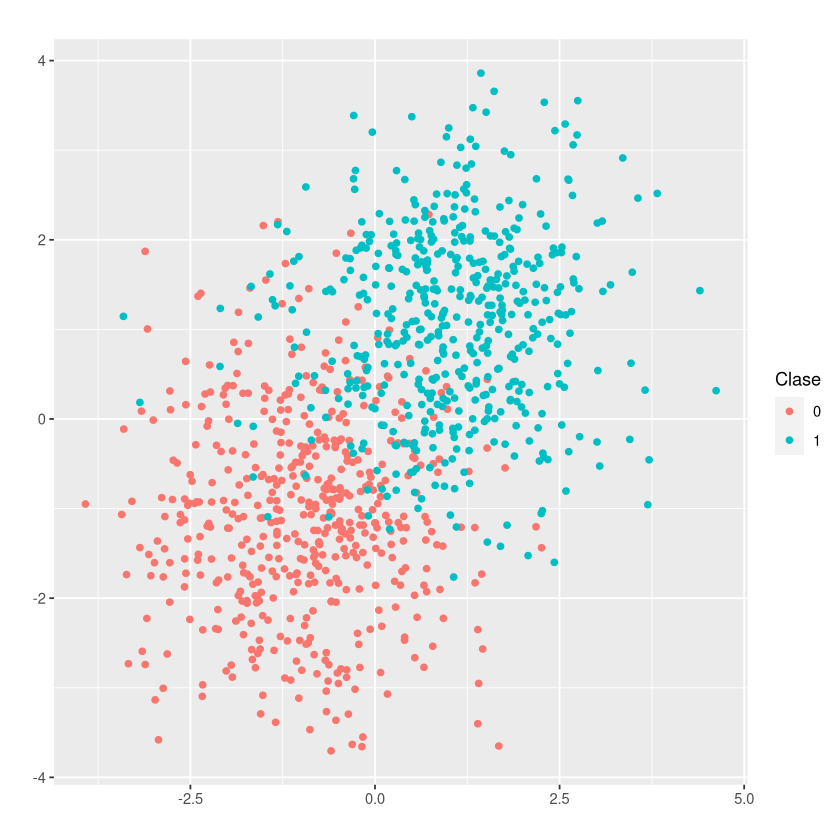

In [32]:
df <- generateDiagonal(2, 1000, 0.78)
# Chequeo la cantidad de cada clase
table(df[, "Class"])
graphDF(df)


   0    1 
2500 2500 

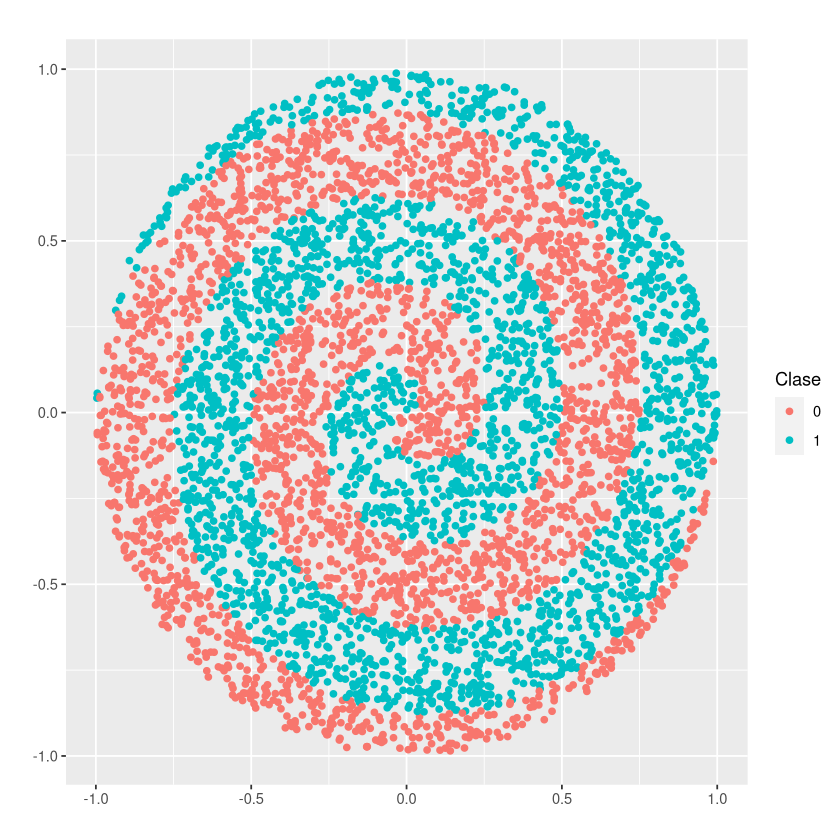

In [33]:
df <- generateSpirals(5000)
# Chequeo la cantidad de cada clase
table(df[, "Class"])
graphDF(df)

--------------------------------------------------------------------------------
## Ejercicio 3

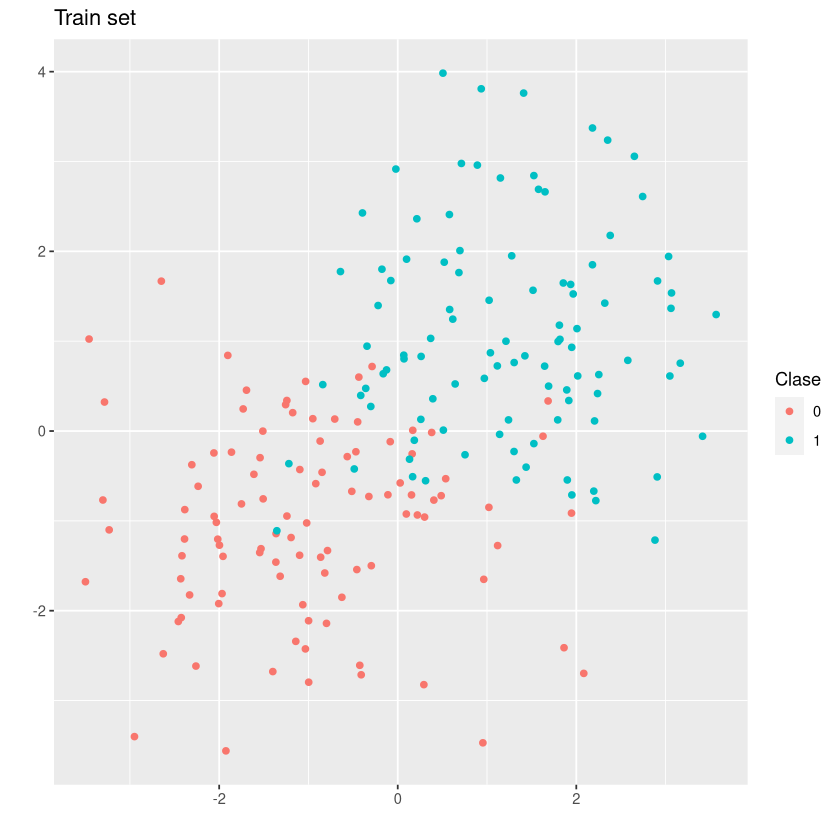

   predictTreeDiagonal
      0   1
  0 880 120
  1 149 851

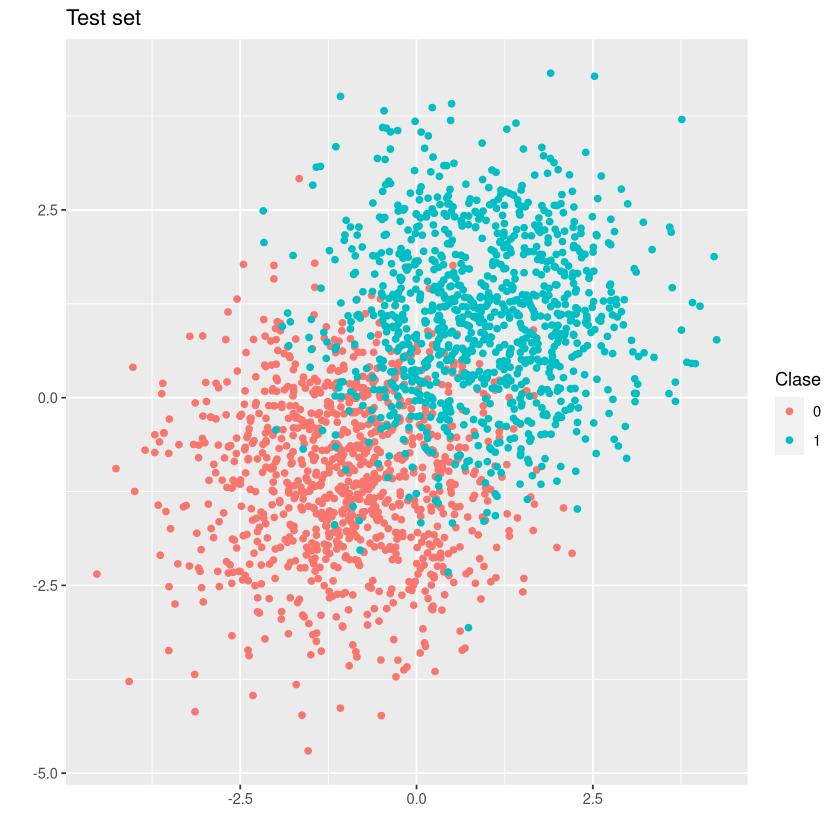

   predictKNNDiagonal
      0   1
  0 993   7
  1  20 980

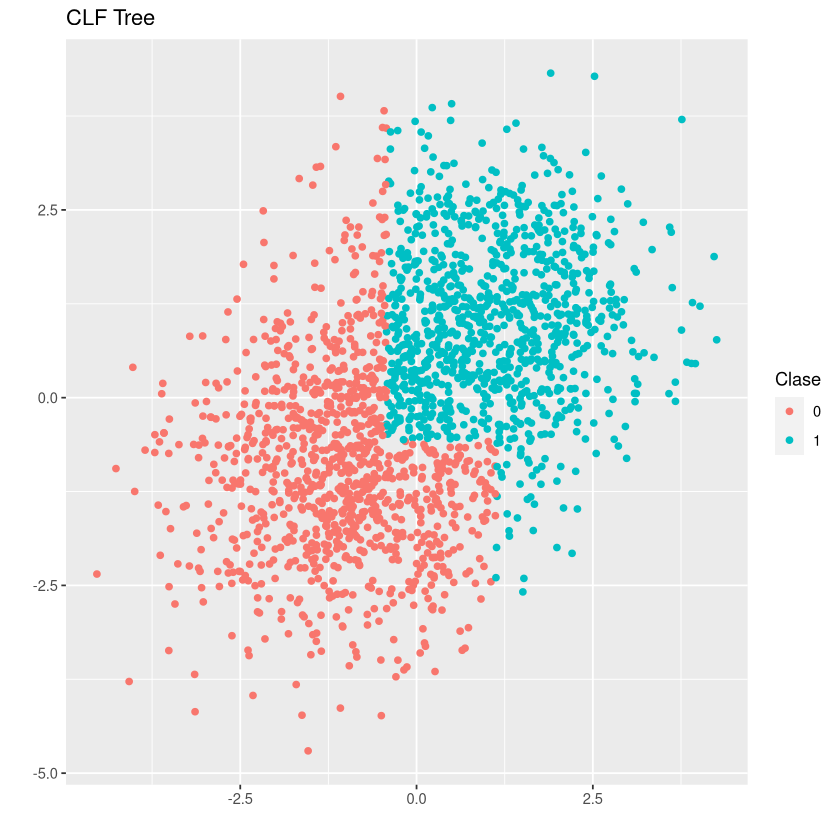

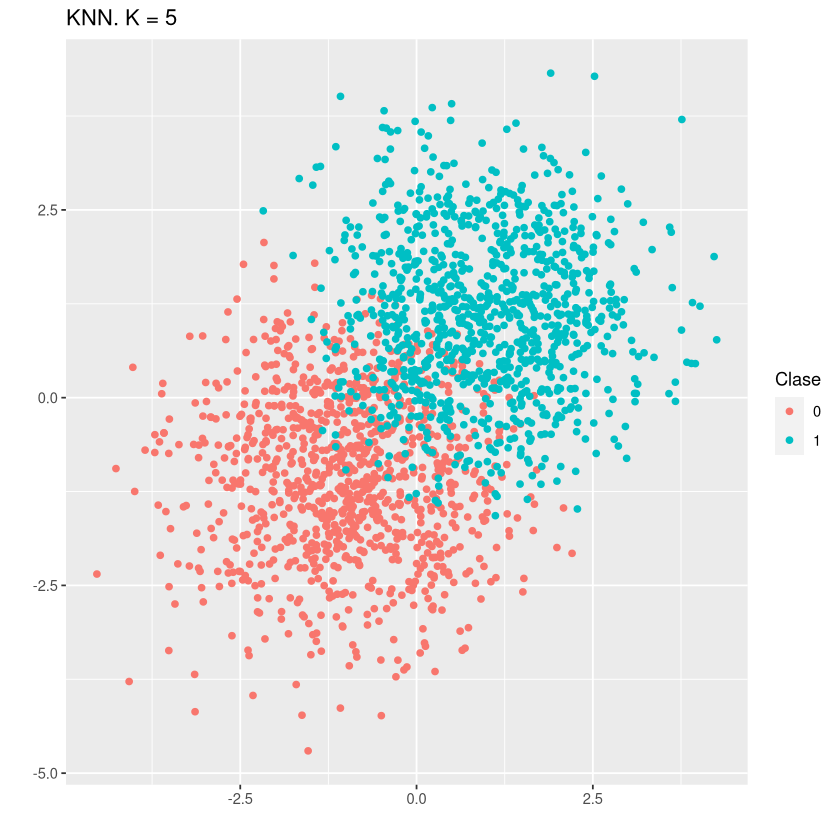

In [56]:
dfTrainDiagonal = generateDiagonal(2, 200, 0.78)
dfTestDiagonal = generateDiagonal(2, 2000, 0.78)

graphDF(dfTrainDiagonal, title = "Train set")
graphDF(dfTestDiagonal, title = "Test set")

treeDiagonal <- ctree(Class ~ ., dfTrainDiagonal)

predictTreeDiagonal <- predict(treeDiagonal, dfTestDiagonal)
table(dfTestDiagonal$Class, predictTreeDiagonal)

dfTreePredict <- dfTestDiagonal
dfTreePredict["Class"] <- predictTreeDiagonal
graphDF(dfTreePredict, title = "Decision Tree")

predictKNNDiagonal <- knn(train = dfTrainDiagonal, test = dfTestDiagonal, 
                          cl = dfTrainDiagonal$Class, k = 5)
table(dfTestDiagonal$Class, predictKNNDiagonal)

dfKNNPredict <- dfTestDiagonal
dfKNNPredict["Class"] <- predictKNNDiagonal
graphDF(dfKNNPredict, title = "KNN. K = 5")


In [ ]:
df_train_spirals = generateSpirals(200)
df_test_spirals = generateSpirals(2000)